In [1]:
import shelve
import re
import os
from predict_price_helpers import *

In [2]:
with shelve.open('./predict-price.shelve', flag='r') as slf:
    for k,v in slf.items():
        print(k)
        globals()[k] = v
        if re.match('def\d+:', k) is not None:
            print(v)
            exec(v) 

RESULTS_DIR
def0:
do_save = lambda fn: not(os.path.isfile(fn))
cfg
num_columns
cat_columns
models
df


In [3]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [4]:
# set figure defaults (needs to be in cell seperate from import sns)
plt.style.use([
    'default',
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/movshon.mplstyle",
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-notebook.mplstyle"
])

# Model: Decision Tree Regression

src: https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html

## Prepare input

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

from sklearn.tree import  DecisionTreeRegressor

model_name = 'Decision Tree Regression'

cat_columns_reduced = list(np.setdiff1d(cat_columns, ['model', 'fuel']))
# Can be reduced here

# list of lists with categories. Needed for column transformer
cats = list(df[cat_columns_reduced].apply(lambda x:pd.Series(x.unique()).dropna().tolist() + ['missing'], axis='index'))

# Use data frame not array
yX = df.dropna(subset=['price'])
X = yX.iloc[:,1:]
y = yX.iloc[:,0]

# Add features
X.loc[:,'usage_intensity'] = X.odometer / X.age
X.loc[:,'classic'] = X.age > 25*365
X.loc[:,'classic'].replace({True:+1, False:-1, np.NaN:0}, inplace=True)

print(X.shape)
print(y.shape)

(9932, 31)
(9932,)


In [6]:
cat_columns_expanded = cat_columns_reduced + ['classic']
cats_added = cats + [['y', 'n', 'missing']]
num_columns_expanded = num_columns + ['usage_intensity']

In [7]:
# Transfer boolean features from categorical to numerical
rm_from_cat = []
cats_added_keep = []
for i,cn in enumerate(cat_columns_expanded):
    print([i, cn, cats_added[i]], end='')
    if {'y', 'n', 'missing'} == set(cats_added[i]):
        print(' << transfer to numerical')
        X.loc[:,cn].replace({'y':+1, 'n':-1, 'missing':0, np.NaN: 0}, inplace=True)
        rm_from_cat += [cn]
    else:
        print('')
        cats_added_keep += [cats_added[i]]
        
# add to num
num_columns_expanded += rm_from_cat
# remove from cat
[cat_columns_expanded.remove(c) for c in rm_from_cat]

print(cat_columns, '\n', cat_columns_reduced, '\n', cat_columns_expanded)
print(num_columns, '\n', num_columns_expanded)

features = num_columns_expanded + cat_columns_expanded

[0, 'automatic_gearbox', ['n', 'y', 'missing']] << transfer to numerical
[1, 'body_type', ['Cabriolet', 'Hatchback', 'Sedan', 'Stationwagen', 'MPV', 'Coupe', 'Vrachtwagen', 'Bestelwagen', 'Opleggertrekker', 'Pick-uptruck', 'Multipurpose vehicle (MPV)', 'missing']]
[2, 'brand', ['ASTON-MARTIN', 'MERCEDES-BENZ', 'BMW', 'RENAULT', 'CITROËN', 'VOLKSWAGEN', 'PORSCHE', 'BENTLEY', 'LEXUS', 'SEAT', 'AUDI', 'HYUNDAI', 'FIAT', 'MINI', 'SUBARU', 'SAAB', 'OPEL', 'SKODA', 'FORD', 'TOYOTA', 'JAGUAR', 'DAIHATSU', 'ALFA ROMEO', 'HONDA', 'PEUGEOT', 'MITSUBISHI', 'VOLVO', 'CHEVROLET', 'LADA-VAZ', 'SUZUKI', 'MAZDA', 'CHRYSLER', 'DODGE', 'MASERATI', 'FERRARI', 'SMART', 'SSANGYONG', 'KIA', 'JEEP', 'LAMBORGHINI', 'AIXAM', 'ROLLS ROYCE', 'HUMMER', 'TRIUMPH', 'DAEWOO', 'NISSAN', 'PONTIAC', 'CADILLAC', 'LAND ROVER', 'LANCIA', 'ROVER', 'DATSUN', 'HYMER', 'DACIA', 'MG', 'LINCOLN', 'TESLA', 'DAIMLER', 'AUSTIN-HEALEY', 'GMC', 'VAUXHALL', 'AUVERLAND', 'UMM-UNIAO METALOMECANICA', 'OLDSMOBILE', 'DAF', 'DS', 'INFINITI

In [8]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)


(6952, 31)
(2980, 31)


In [9]:
# Create model

# Preprocessor: numerical features
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
)
# Preprocessor: categorical features
cat_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing', missing_values=np.NaN),
    OneHotEncoder(categories=cats_added_keep),
)

# Preprocess: fuels
# list of all fuels is passed by using full data set! (X)
fuel_list = list(get_unique_fuels(merge_lpg_and_lpgtype(X.fuel)))
get_fuel_dummies = DummyfyFuel(fuel_list)


# Combine num and cat
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_transformer, pd.Index(num_columns_expanded)),
    ('categorical', cat_transformer, pd.Index(cat_columns_expanded)),
    ('onehot_fuel', get_fuel_dummies, 'fuel')
], verbose=False)

# full pipeline with preproc and dtr
dtr = make_pipeline(
    preprocessor,
    DecisionTreeRegressor()
)

# Target transformation: log transform price
pl = TransformedTargetRegressor(
    regressor=dtr,
    func=np.log10,
    inverse_func=pow10
)

In [10]:
def plot_gscv_result(gscv, param_name = None):
    '''
    plot search results    
    '''
    
    if param_name is None:
        param_name = re.sub('^.+?__', '', list(gscv.param_grid[0].keys())[0])
    
    plt.figure(figsize=[2,2])

    # abscissa
    alphas = list(gscv.cv_results_['param_regressor__' + param_name])

    # plot mean
    r2_mean = gscv.cv_results_['mean_test_score']
    # normalize
    r2_mean = (r2_mean-r2_mean.mean())/r2_mean.std()
    plt.plot(alphas, r2_mean, label='mean', lw=4, color='blue')

    # plot folds
    for fold in range(gscv.cv):
        r2_fold = gscv.cv_results_['split{:.0f}_test_score'.format(fold)]
        # normalize
        r2_fold = (r2_fold-r2_fold.mean())/r2_fold.std()
        plt.plot(alphas, r2_fold, label='fold ' + str(fold), lw=1, color='black')

    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('standardized r2 score [a.u.]')
    plt.axvline(gscv.best_params_['regressor__' + param_name], linewidth=2, linestyle='--', color='k')
    result = 'grid search results\nbest {:s}={:.5f}'.format(param_name, gscv.best_params_['regressor__' + param_name])
    plt.title(result)
    print(result)
    plt.legend(ncol=1, loc='center left', bbox_to_anchor=(1,0.5))
    
    return gscv.best_estimator_

In [11]:
def gs_dtr_depth(pipeline):
    # grid search estimator
    grid_search_depth = GridSearchCV(
        estimator=pipeline,
        param_grid=[
            {
                'regressor__decisiontreeregressor__max_depth': 2**np.arange(1,7) # Choose param such that a clear peaked graph is shown in next plot
            } 
        ],
        cv=8,
        scoring='r2',
        n_jobs=-1,
        verbose=10,
    )

    # Perform grid search
    grid_search_depth.fit(X_train, y_train);
    
    return grid_search_depth

Fitting 8 folds for each of 6 candidates, totalling 48 fits
grid search results
best decisiontreeregressor__max_depth=16.00000


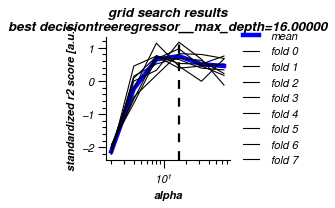

In [12]:
best_estimator = plot_gscv_result(gs_dtr_depth(pl))

### Fit

In [13]:
# Store estimator with best hyper parameter
reg = best_estimator
models[model_name].update({'model':reg})

# fit
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
importance = reg.regressor_.steps[-1][1].feature_importances_
models[model_name].update({'importance': importance})
models[model_name].update({'n effective features':(importance > 0).sum()})
#betas = [reg.regressor_.steps[-1][1].intercept_, *reg.regressor_.steps[-1][1].coef_]
#models[model_name].update({'betas':betas})
#models[model_name].update({'n betas effective':(np.abs(betas) > 0).sum()})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})

In [14]:
# Make labels for tree nodes

# In descision tree every categorical value (like "brand_VW") is a feature.
# Some categorical columns are transfromed to numerical. These are not seperated features.

feats = [features] + cats_added

# Numerical labels
lbls = [f for f in features if f in num_columns_expanded] 

# Add column name as prefix for categorical
for i,cn in enumerate(cat_columns_expanded):
    lbls += [f'{cn}_{c}_yn' for c in cats_added_keep[i]]

# Add fuels
cn = 'fuel'
lbls += [f'{cn}_{f}_yn' for f in fuel_list]



/home/tom/bin/satdatsci/Saturday-Datascience/results/Decision_Tree_Regression.png


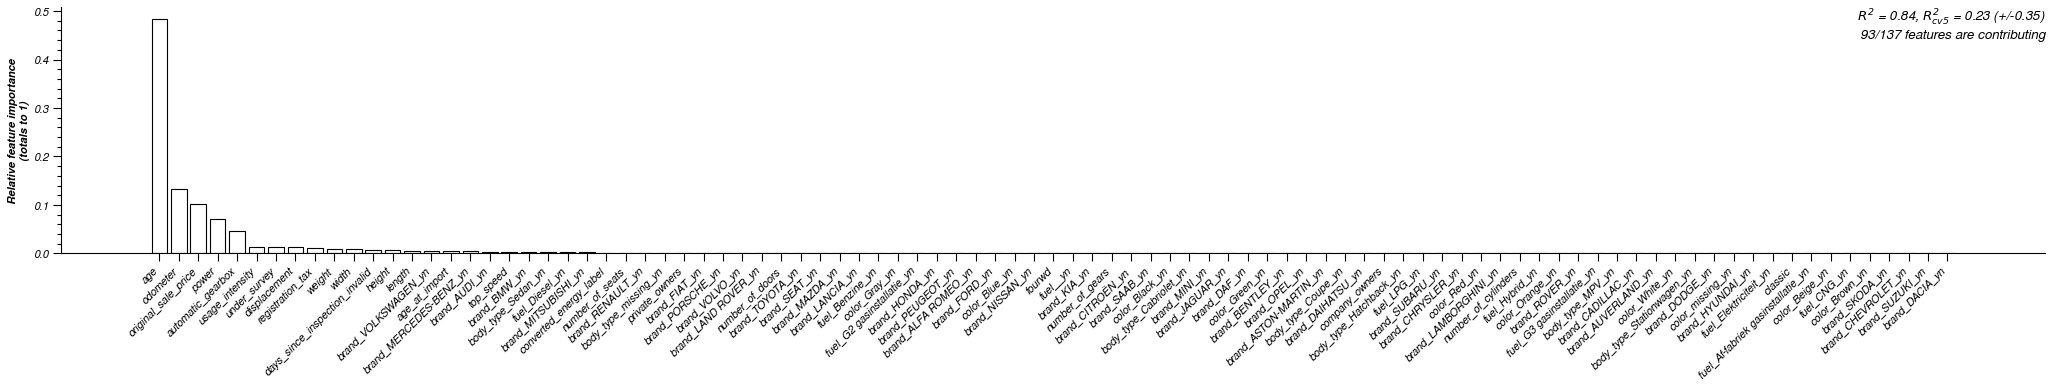

In [15]:
# plot feature importance (sum is 1)
order = np.argsort(reg.regressor_.steps[-1][1].feature_importances_)[::-1]

f = plt.figure(figsize=(32,4))
ax = f.gca()
h = reg.regressor_.steps[-1][1].feature_importances_[order]
stats = f"""
$R^2$ = {models[model_name]['R^2']:.2f}, 
$R^2_{{cv{models[model_name]['cv R^2'].shape[0]:g}}}$ = 
{np.mean(models[model_name]['cv R^2']):.2f} 
(+/-{np.std(models[model_name]['cv R^2']):.2f})
""".replace('\n','')
x = np.array(lbls)[order]
sel = h>0 # disregard features without contribution
ax.bar(height=h[sel], x=x[sel], facecolor='None')
ax.set_xticks(range(sum(sel)))
ax.set_xticklabels(labels=x[sel], rotation=45, va='top', ha='right', style='italic', fontsize=10)
ax.xaxis.set_tick_params(rotation=45)
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.set_ylabel('Relative feature importance\n(totals to 1)')
ax.annotate(
    f'{stats:s}\n{sum(sel)}/{len(sel)} features are contributing',
    (1,1), xycoords='axes fraction', ha='right', va='top')

# Save
file_name = f"{RESULTS_DIR}/{model_name.replace(' ','_')}.png"
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

In [16]:
fn = './predict-price.shelve'
with shelve.open(fn, flag='w') as slf:
    slf['models'] = models 
    print(f'Shelve file [{fn}] contains models:')
    for m in slf['models'].keys():
        print(f'\t{m}')

Shelve file [./predict-price.shelve] contains models:
	linear regression no cv
	linear regression log price young
	MLR reduced observations
	MLR impute median
	MLR with categorical
	MLR Lasso
	MLR added features
	Decision Tree Regression


In [17]:
assert False, 'stop running, below is sandboxing and testing'

AssertionError: stop running, below is sandboxing and testing

In [26]:
best_estimator.predict(X)

array([19101., 21751., 19000., ...,  1333.,  1810.,  4752.])

In [27]:
X

,brand,model,age,fuel,odometer,days_since_inspection_invalid,age_at_import,body_type,displacement,number_of_cylinders,...,width,automatic_gearbox,number_of_gears,energy_label,private_owners,company_owners,under_survey,converted_energy_label,usage_intensity,classic
2014-10-2001,MERCEDES-BENZ,"E 220 CDI, automatic",NaN,NaN,176639.0,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-1
2014-10-2002,MERCEDES-BENZ,"S 350, automatic",NaN,NaN,76655.0,-547.0,NaN,NaN,NaN,NaN,...,NaN,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-1
2014-10-2003,MERCEDES-BENZ,e 200 cgi,1609.0,Benzine,205627.0,-2973.0,0.0,Cabriolet,1796.0,4.0,...,1786.0,1.0,5.0,G,7.0,1.0,-1.0,6.0,127.798011,-1
2014-10-2004,MERCEDES-BENZ,"E350, automatic",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-1
2014-10-2005,BMW,"530D, automatic",NaN,NaN,163227.0,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-704203,PEUGEOT,107,5615.0,Benzine,103723.0,-237.0,0.0,Hatchback,998.0,3.0,...,1630.0,-1.0,5.0,D,3.0,0.0,-1.0,3.0,18.472484,-1
2024-02-704303,TOYOTA,yaris,6580.0,Benzine,255913.0,6.0,0.0,Multipurpose vehicle (MPV),1298.0,4.0,...,1695.0,-1.0,5.0,G,3.0,0.0,-1.0,6.0,38.892553,-1
2024-02-705003,VOLKSWAGEN,polo,6779.0,Benzine,162715.0,20.0,5613.0,Hatchback,1198.0,3.0,...,NaN,-1.0,NaN,nan,2.0,0.0,-1.0,7.0,24.002803,-1
2024-02-705303,RENAULT,megane scenic,5572.0,Benzine,194833.0,824.0,0.0,Hatchback,1598.0,4.0,...,1810.0,-1.0,6.0,G,2.0,0.0,-1.0,6.0,34.966439,-1


In [ ]:
r = reg.regressor_.steps[-1][1]
t = r.tree_
t?

In [ ]:
reg.inverse_func(values[0])

In [ ]:
values = [reg.inverse_func(v[0][0]) for v in t.value]
labels = [lbls[f] for f in t.feature]
df_tree = pd.DataFrame(data=[labels, t.threshold, values], index=['label', 'threshold', 'value']).T
df_tree

In [ ]:
df_tree.label.value_counts()

In [ ]:
for n,g in df_tree.groupby('label'):
    #print(n)
    if not n.endswith('_yn'):
        vc = g.threshold.value_counts();
        vc.name=n
        display(vc)

In [ ]:
reg

In [ ]:
plt.plot(np.log10(y_test), np.log10(y_pred), 's', mec='None', mfc='k', alpha=1/8, ms=4)

In [ ]:
from sklearn import tree
f = plt.figure(figsize=[32, 32], dpi=400)
ax = f.gca()

tree.plot_tree(reg.regressor_.steps[-1][1], ax=ax, max_depth=2, feature_names=lbls)
plt.show()

In [ ]:
reg.regressor_

In [ ]:
# tree.export_graphviz(reg.regressor_.steps[-1][1], 'tmp.txt')

In [ ]:
# pwd